In [1]:
!mkdir -p data
!curl 'https://s3.amazonaws.com/starfish.data.spacetx/spacejam2/MERFISH_Allen_VISp/Allen_MERFISH_spots_with_anatomy.csv' > data/Allen_MERFISH_spots_with_anatomy.csv
!curl 'https://raw.githubusercontent.com/spacetx-spacejam/data/master/gene_lists/MERFISH_genes.csv' > data/MERFISH_genes.csv
!curl 'https://s3.amazonaws.com/starfish.data.spacetx/spacejam2/MERFISH_Allen_VISp/fixed_1001844875.csv' > data/fixed_1001844875.csv
!curl 'https://raw.githubusercontent.com/spacetx-spacejam/data/master/annotations/Allen_MERFISH_Layers.geojson' > data/Allen_MERFISH_Layers.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  319M  100  319M    0     0  22.7M      0  0:00:14  0:00:14 --:--:-- 25.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2524  100  2524    0     0   8901      0 --:--:-- --:--:-- --:--:--  8887
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1500k  100 1500k    0     0  1203k      0  0:00:01  0:00:01 --:--:-- 1204k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2621  100  2621    0     0   8370      0 --:--:-- --:--:-- --:--:--  8373


In [2]:
##
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import json
import matplotlib
import matplotlib.pyplot as plt
import os
import pathlib
import math

In [3]:
plt.style.use("dark_background")

In [4]:
##
output_dir = 'output'
os.makedirs(output_dir)

In [5]:
##
class BoundingBox:
    pass

In [6]:
bb = BoundingBox()
bb.x0 = 2000
bb.x1 = 2400
bb.y0 = 4800
bb.y1 = 5200
# bb.x0 = 1600
# bb.x1 = 2900
# bb.y0 = 5100
# bb.y1 = 6400

#

In [7]:
# loads point data
df = pd.read_csv("data/Allen_MERFISH_spots_with_anatomy.csv")
plt.figure(figsize=(10, 10))
df = df[
    (df["x_um"] > bb.x0)
    & (df["x_um"] < bb.x1)
    & (df["y_um"] > bb.y0)
    & (df["y_um"] < bb.y1)
]
xy = df[["x_um", "y_um"]].to_numpy()
a_points = ad.AnnData(obs=list(range(len(xy))))
a_points.obsm["spatial"] = xy
a_points.obsm["cell_type"] = df["layer"].to_numpy()
a_points.obs.columns = ['0']
a_points.write_h5ad(os.path.join(output_dir, 'points.h5ad'))

<Figure size 720x720 with 0 Axes>

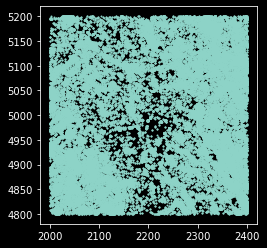

In [8]:
##
plt.figure()
plt.scatter(xy[:, 0], xy[:, 1], s=1)
plt.gca().set_aspect("equal")
plt.show()

In [9]:
##
def plot_single_molecule_anndata(adata: ad.AnnData, ax=None):
    xy = adata.obsm["spatial"]
    c = adata.obsm["cell_type"]
    if ax is None:
        plt.figure(figsize=(10, 10))
        cax = plt.gca()
    else:
        cax = ax
    all_types = list(set(c))
    cax.scatter(xy[:, 0], xy[:, 1], s=1, c=[all_types.index(cc) for cc in c])
    cax.set_aspect("equal")
    if ax is None:
        plt.show()

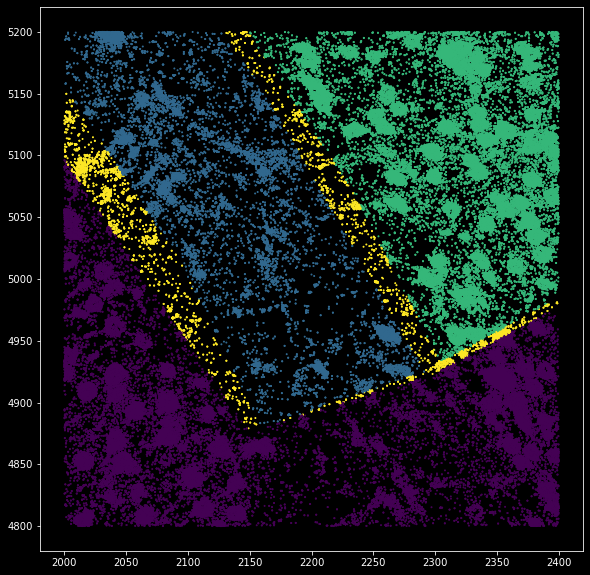

In [10]:
plot_single_molecule_anndata(a_points)

In [11]:
##
# loads single cell masks data
df = pd.read_csv("data/fixed_1001844875.csv")
df.drop(columns=[df.columns[0], df.columns[1]], inplace=True)
df["radius"] = df["area"].apply(lambda x: math.sqrt(x / math.pi))
genes = df.columns.tolist()
genes = genes[: genes.index("area")]
xy = df[["x_um", "y_um"]].to_numpy()

In [12]:
a_cells = ad.AnnData(X=df[genes])
a_cells.obsm["spatial"] = xy
a_cells.obsm["region_radius"] = df["radius"].to_numpy()
a_cells.write_h5ad(os.path.join(output_dir, 'cells.h5ad'))

/Users/macbook/miniconda3/envs/39/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
##
def plot_shape_masks_anndata(adata: ad.AnnData, ax=None):
    if ax is None:
        plt.figure(figsize=(10, 10))
        cax = plt.gca()
    else:
        cax = ax
    xy = adata.obsm["spatial"]
    radius = adata.obsm["region_radius"]
    patches = []
    for (x, y), r in zip(xy, radius):
        if bb.x0 - r < x < bb.x1 + r and bb.y0 - r < y < bb.y1 + r:
            patch = matplotlib.patches.Circle(
                (x, y), r, color=np.append(np.random.rand(3), 0.3)
            )
            patches.append(patch)
    p = matplotlib.collections.PatchCollection(patches, match_original=True)
    cax.add_collection(p)
    cax.set(xlim=(bb.x0, bb.x1), ylim=(bb.y0, bb.y1))
    cax.set_aspect("equal")
    if ax is None:
        plt.show()

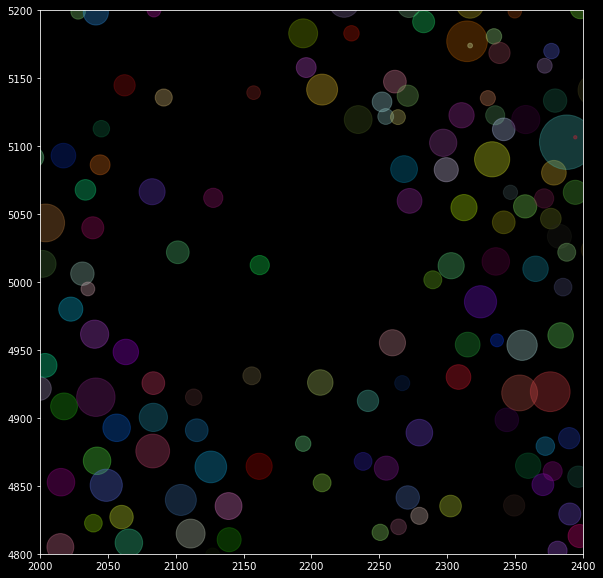

In [14]:
plot_shape_masks_anndata(a_cells)

#

In [15]:
# generate the raster image
import datashader
import colorcet

In [16]:
df = pd.read_csv("data/Allen_MERFISH_spots_with_anatomy.csv")
df['datashader'] = np.array([1] * len(df))
raster_w = 600
raster_h = 600
cvs = datashader.Canvas(plot_width=raster_w, plot_height=raster_h)
agg = cvs.points(df, x="x_um", y="y_um", agg=datashader.any())
# img = datashader.tf.shade(agg)
# raster = img.to_numpy()
raster = agg.to_numpy()
raster = raster.astype(np.float64)
raster /= raster.max()
raster = np.flipud(raster)
# raster = np.log(1 + raster)

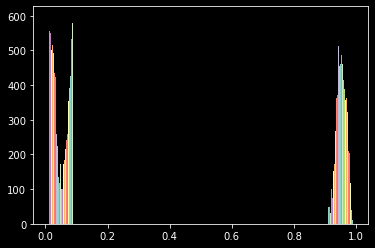

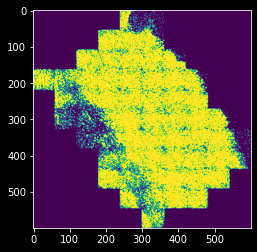

In [17]:
plt.figure()
len(df)
# plt.hist(raster.flatten())
plt.hist(raster)
# plt.hist(raster.flatten()[raster.flatten() >1000], bins=1000)
plt.show()
##
plt.figure()
plt.imshow(raster)
# plt.xlim([400, 600])
# plt.ylim([0, 200])
plt.show()

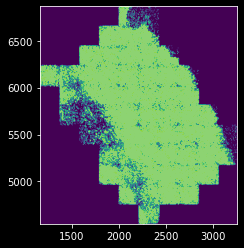

In [18]:
##
plt.figure()
plt.imshow(
    raster,
    extent=(df["x_um"].min(), df["x_um"].max(), df["y_um"].min(), df["y_um"].max()),
)
plt.scatter(df["x_um"], df["y_um"], s=1, alpha=0.01)
plt.show()

In [19]:
##
min_x = df["x_um"].min()
min_y = df["y_um"].min()
max_x = df["x_um"].max()
max_y = df["y_um"].max()

In [20]:
raster_bb = BoundingBox()
raster_bb.x0 = int((bb.x0 - min_x) / (max_x - min_x) * raster_w)
raster_bb.x1 = int((bb.x1 - min_x) / (max_x - min_x) * raster_w)
raster_bb.y0 = int((bb.y0 - min_y) / (max_y - min_y) * raster_h)
raster_bb.y1 = int((bb.y1 - min_y) / (max_y - min_y) * raster_h)
print(
    f"raster_bb.x0 = {raster_bb.x0}, raster_bb.x1 = {raster_bb.x1}, raster_bb.y0 = {raster_bb.y0}, raster_bb.y1 = {raster_bb.y1}"
)

raster_bb.x0 = 241, raster_bb.x1 = 355, raster_bb.y0 = 65, raster_bb.y1 = 168


In [21]:
raster_crop = np.flipud(np.flipud(raster)[raster_bb.y0 : raster_bb.y1, raster_bb.x0 : raster_bb.x1])
print(raster_crop.shape)

(103, 114)


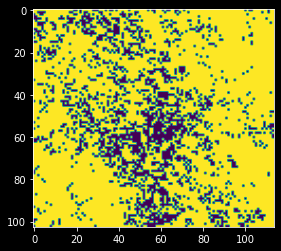

In [22]:
plt.figure()
plt.imshow(raster_crop)
plt.show()
##
translation = np.array([bb.x0, bb.y0])
# expecting the scale factor to be the same in both axes, and checking this
assert bb.x1 - bb.x0 == bb.y1 - bb.y0
assert raster_w == raster_h
scale_factor = (bb.x1 - bb.x0) / raster_w
##
np.save(os.path.join(output_dir, 'image.np'), raster_crop)

In [23]:
d = {}
d['translation_x'] = float(translation[0])
d['translation_y'] = float(translation[1])
d['scale_factor'] = scale_factor
with open(os.path.join(output_dir, 'image_transform.json'), 'w') as outfile:
    json.dump(d, fp=outfile)

In [24]:
##
print(f"translation = {translation}, scale_factor = {scale_factor}")
x0 = translation[0]
y0 = translation[1]
x1 = translation[0] + raster.shape[1] * scale_factor
y1 = translation[1] + raster.shape[0] * scale_factor
extent = (x0, x1, y0, y1)
print(extent)

translation = [2000 4800], scale_factor = 0.6666666666666666
(2000, 2400.0, 4800, 5200.0)


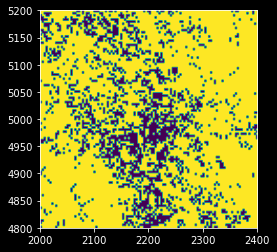

In [25]:
plt.figure()
plt.imshow(raster_crop, extent=extent)
plt.show()
##

In [26]:
# first translation, then scaling
def plot_raster(
    raster: np.ndarray, translation: np.array, scale_factor: float, ax=None
):
    assert len(translation) == 2
    # grayscale image or rgb/rgba
    assert (
        len(raster.shape) == 2 or len(raster.shape) == 3 and raster.shape[2] in [3, 4]
    )
    if ax is None:
        plt.figure(figsize=(10, 10))
        cax = plt.gca()
    else:
        cax = ax
    x0 = translation[0]
    y0 = translation[1]
    x1 = translation[0] + raster.shape[1] * scale_factor
    y1 = translation[1] + raster.shape[0] * scale_factor
    extent = (x0, x1, y0, y1)
    cax.imshow(raster_crop, extent=extent, cmap=plt.cm.get_cmap('gray'), alpha=0.4)
    if ax is None:
        plt.show()

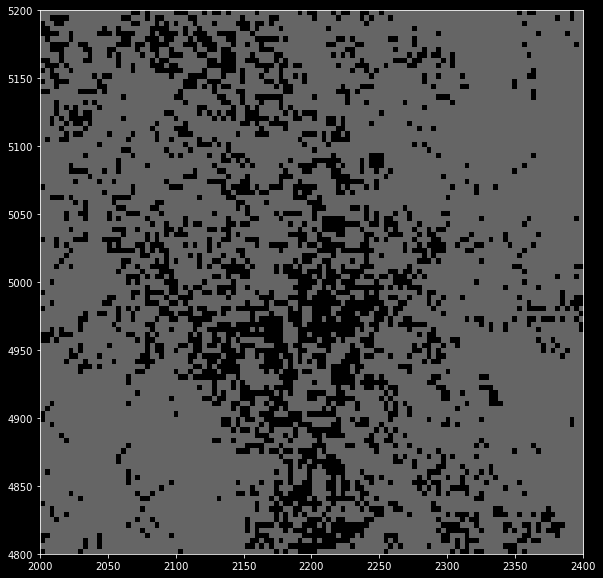

{'type': 'GeometryCollection',
 'geometries': [{'type': 'Polygon',
   'name': 'L1',
   'coordinates': [[[2435.069566, 6500.284703],
     [2476.390162, 6535.178868],
     [2534.993939, 6471.307336],
     [2743.287325, 6256.796237],
     [2892.512438, 6045.393994],
     [3110.132394, 5597.718655],
     [3175.960311, 5399.368749],
     [3130.896017, 5374.899385],
     [3077.489401, 5557.30352],
     [2850.542875, 6011.196572],
     [2712.19876, 6214.826674],
     [2493.024376, 6434.001058],
     [2435.069566, 6500.284703]]]},
  {'type': 'Polygon',
   'name': 'L4',
   'coordinates': [[[2099.296063, 6218.987584],
     [2143.972428, 6257.045228],
     [2145.859029, 6257.045228],
     [2146.338866, 6256.459168],
     [2151.558392, 6260.866921],
     [2210.003484, 6332.509292],
     [2221.323093, 6321.189682],
     [2222.09221, 6320.430889],
     [2259.341867, 6351.887251],
     [2357.789117, 6236.588669],
     [2668.674769, 5824.665181],
     [2827.226451, 5490.463105],
     [2914.2115, 5257.

In [27]:
plot_raster(raster, translation=translation, scale_factor=scale_factor)
##
# polygon information
layers = json.load(open('data/Allen_MERFISH_Layers.geojson', 'r'))
layers

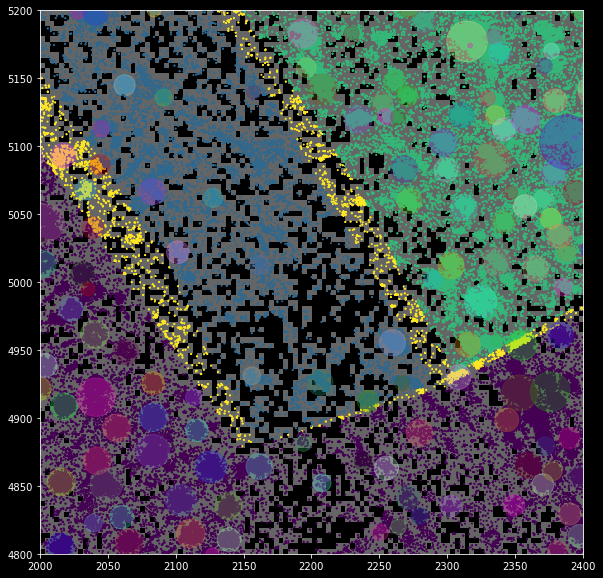

In [28]:
##
plt.figure(figsize=(10, 10))
ax = plt.gca()
plot_single_molecule_anndata(a_points, ax)
plot_shape_masks_anndata(a_cells, ax)
plot_raster(raster, translation=translation, scale_factor=scale_factor, ax=ax)
plt.show()

In [29]:
##
brain_layers = {}
for layer in layers['geometries']:
    name = layer['name']
    coordinates = np.array(layer['coordinates'])
    coordinates = np.squeeze(coordinates, 0)
    brain_layers[name] = coordinates

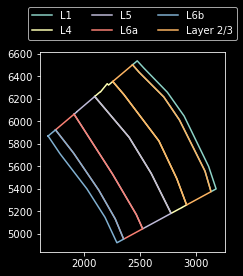

In [30]:
##
plt.figure()
for layer, coordinates in brain_layers.items():
    plt.plot(coordinates[:, 0], coordinates[:, 1])
plt.gca().set_aspect('equal')
plt.legend([layer for layer in brain_layers.keys()], loc='upper center', bbox_to_anchor=(.5, 1.25), ncol=3)
plt.tight_layout()
plt.show()

#